# Preparation

## Import Used Libraries

In [186]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import math
import json

## Read Image

In [187]:
def readimage(path):
    return img.imread(path)

def showimage(image):
    plt.imshow(image)

## RGB to Hue Conversion

In [188]:
def RGB2Hue(r, g, b):
    r = r / 255
    g = g / 255
    b = b / 255
    
    maxc = max(r, g, b)
    minc = min(r, g, b)
    rang = maxc - minc
    hue = 0
    
    if rang == 0:
        return 0
    
    if maxc == r:
        hue = (g-b)/rang
    elif maxc == g:
        hue = 2.0 + (b-r)/rang
    else:
        hue = 4.0 + (r-g)/rang
    
    return (round(hue * 60) + 360) % 360

## Calculate Histogram

In [189]:
def histogram(image):
    R = [0] * 256
    G = [0] * 256
    B = [0] * 256
    H = [0] * 360
    
    unit = 1.0 / (len(image) * len(image[0]))
    
    for row in image:
        for pixel in row:
            r, g, b = pixel
            h = RGB2Hue(r, g, b)
            R[r] += unit
            G[g] += unit
            B[b] += unit
            H[h] += unit
        
    return (R, G, B, H)

## Calculate Distances   

In [190]:
def eucdist(vecA, vecB):
    pairs = list(zip(vecA, vecB))
    total = sum((a-b)**2 for a, b in pairs)
    return math.sqrt(total)

def histdist(histsA, histsB):
    histpairs = list(zip(histsA, histsB))
    histdists = list(map(lambda p: eucdist(*p), histpairs))
    return histdists

def imagedist(histsA, histsB):
    histdists = histdist(histsA, histsB)
    rgbdist = eucdist([0,0,0], histdists[:3]) / math.sqrt(3) # max distance
    huedist = histdists[-1]
    return (rgbdist, huedist)

def similarity(histsA, histsB):
    rgbdist, huedist = imagedist(histsA, histsB)
    return (1 - rgbdist, 1 - huedist)

## Test Distance

In [191]:
# img1 = readimage('../images/seahorse/image_0021.jpg')
# img2 = readimage('../images/octopus/image_0030.jpg')

# hists1 = histogram(img1)
# hists2 = histogram(img2)

# rgbsim, huesim = similarity(hists1, hists2)

# print(rgbsim)
# print(huesim)

## Collect Histograms of Train Images

In [192]:
def getfiles(dirpath):
    files = next(os.walk(dirpath), (None, None, []))[2]
    files = [file for file in files if file[0] != '.']
    files.sort()
    return files

def train(root, folders, size):
    data = []
    
    for folder in folders:
        dirpath = os.path.join(root, folder)
        files = getfiles(dirpath)
        
        for file in files[:size]:
            abspath = os.path.join(dirpath, file)
            print(f"Training {abspath}") 
            
            image = readimage(abspath)
            hists = histogram(image)
            
            data.append({
                'path': abspath,
                'category': folder,
                'histograms': hists
            })
            
    with open('model.json', 'w') as outfile:
        json.dump(data, outfile)
        
    print("Training done, model saved.")
    
def loadmodel():
    with open('model.json') as jsonfile:
        data = json.load(jsonfile)
        
    return data;

## Retrieve Most Similar N Images From Model

In [193]:
def retrieve(model, image, n):
    targethists = histogram(image)
    similars = []
    
    for source in model:
        sourcehists = source['histograms']
        closeness = similarity(targethists, sourcehists)
        
        similars.append({
            'rgb': closeness[0],
            'hue': closeness[1],
            'path': source['path'],
            'category': source['category']
        })
    
    rgb = sorted(similars, key=lambda x: x['rgb'], reverse=True)
    hue = sorted(similars, key=lambda x: x['hue'], reverse=True)
    
    return (rgb[:n], hue[:n])

# Test Retrieval

In [194]:
# model = loadmodel()
# image = readimage('../images/octopus/image_0030.jpg')
# mostsimilars = retrieve(model, image, 5)

# print(json.dumps(mostsimilars, indent=2))

## Find Most Similar Images of Test Images

In [195]:
def test(root, folders, after):
    model = loadmodel()
    results = []
    
    for category in folders:
        dirpath = os.path.join(root, category)
        files = getfiles(dirpath)
        
        for file in files[after:]:
            abspath = os.path.join(dirpath, file)
            
            result = {
                'path': abspath,
                'category': category,
                'rgb':{'success':False, 'results':[]},
                'hue':{'success':False, 'results':[]}
            }
            
            image = readimage(abspath)
            rgb, hue = retrieve(model, image, 5)
            
            result['rgb']['success'] = any(match['category'] == category for match in rgb)
            result['hue']['success'] = any(match['category'] == category for match in hue)
            result['rgb']['results'] = rgb
            result['hue']['results'] = hue
            
            # print(f"Testing {abspath} {result['rgb']['success']} {result['hue']['success']}") 
            
            results.append(result)
            
    return results

## Calculate Test Report

## Main Flow

**Configure Dataset**

In [196]:
ds_root = '../images'
ds_folders = ['elephant', 'flamingo', 'kangaroo', 'leopards', 'octopus', 'seahorse']
ds_train_size = 20

**Train Model**

In [197]:
# train(ds_root, ds_folders, ds_train_size)

**Find Results**

In [198]:
results = test(ds_root, ds_folders, ds_train_size)

In [199]:
def analyze(results):
    total = 0
    success = {'rgb':0, 'hue':0}
    report = {'total':0, 'success':success, 'categories':{}}
    cats = []
    
    for result in results:
        report['total'] += 1
        
        cat = result['category']
        if cat not in report['categories']:
            cats.append(cat)
            report['categories'][cat] = {
                'total':0,
                'success':{'rgb':0, 'hue':0},
                'rates':{'rgb':0, 'hue':0}
            }
        
        catobj = report['categories'][cat]
        rgbsuccess = int(result['rgb']['success'])
        huesuccess = int(result['hue']['success'])
        
        success['rgb'] += rgbsuccess
        success['hue'] += huesuccess
        catobj['total'] += 1
        catobj['success']['rgb'] += rgbsuccess
        catobj['success']['hue'] += huesuccess
    
    for cat in cats:
        obj = report['categories'][cat]
        total = obj['total']
        obj['rates']['rgb'] = obj['success']['rgb'] / total
        obj['rates']['hue'] = obj['success']['hue'] / total
    
    return report

**Generate Report**

In [200]:
report = analyze(results)
print(json.dumps(report, indent=2))

{
  "total": 60,
  "success": {
    "rgb": 37,
    "hue": 40
  },
  "categories": {
    "elephant": {
      "total": 10,
      "success": {
        "rgb": 7,
        "hue": 6
      },
      "rates": {
        "rgb": 0.7,
        "hue": 0.6
      }
    },
    "flamingo": {
      "total": 10,
      "success": {
        "rgb": 3,
        "hue": 7
      },
      "rates": {
        "rgb": 0.3,
        "hue": 0.7
      }
    },
    "kangaroo": {
      "total": 10,
      "success": {
        "rgb": 8,
        "hue": 7
      },
      "rates": {
        "rgb": 0.8,
        "hue": 0.7
      }
    },
    "leopards": {
      "total": 10,
      "success": {
        "rgb": 10,
        "hue": 8
      },
      "rates": {
        "rgb": 1.0,
        "hue": 0.8
      }
    },
    "octopus": {
      "total": 10,
      "success": {
        "rgb": 7,
        "hue": 5
      },
      "rates": {
        "rgb": 0.7,
        "hue": 0.5
      }
    },
    "seahorse": {
      "total": 10,
      "success": {
     

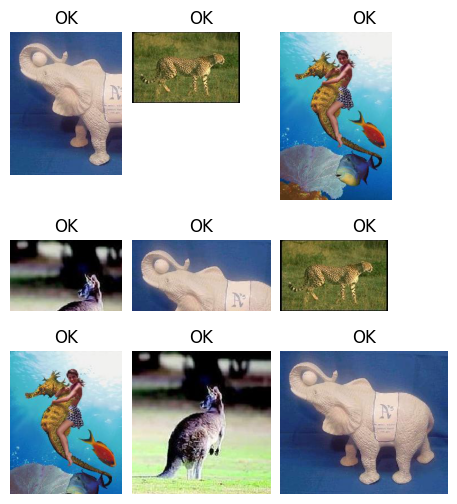

In [224]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

im1 = readimage('../images/elephant/image_0030.jpg') # np.arange(100).reshape((10, 10))
im2 = readimage('../images/leopards/image_0030.jpg') # im1.T
im3 = readimage('../images/seahorse/image_0030.jpg') # np.flipud(im1)
im4 = readimage('../images/kangaroo/image_0030.jpg') # np.fliplr(im2)

fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=(0.1, 0.4),  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4, im1, im2, im3, im4, im1]):
    # Iterating over the grid returns the Axes.
    
    ax.imshow(im)
    ax.set_title('OK')
    ax.set(facecolor = "black")
    ax.minorticks_off()
    ax.set_axis_off()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(visible=True)

plt.show()

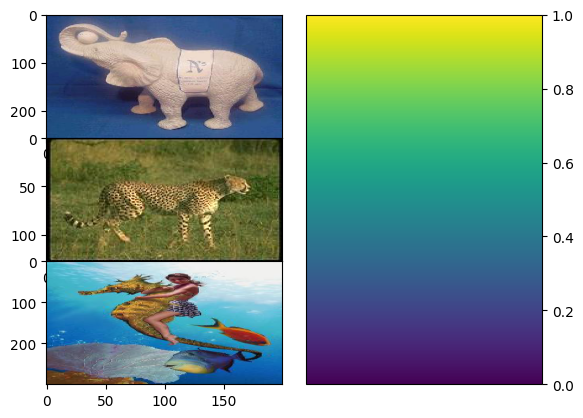

In [229]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(3, 2, width_ratios=[1,1])
fig = plt.figure()
fig.subplots_adjust(wspace=0.1, hspace=0)

ims = [im1, im2, im3, im4]

norm=plt.Normalize(0,1)
for i in range(3):
    ax = fig.add_subplot(gs[i,0])
    im= ax.imshow(ims[i], norm=norm, aspect="auto")

cax = fig.add_subplot(gs[:,1])
fig.colorbar(im, cax=cax)

plt.show()